# Modelowanie tematyczne (ang. *topic modeling*)

W tej sekcji następuje główna część projektu, czyli zastosowanie algotymu modelowania tematycznego. 

Do analizy wybrany został algorytm **LDA** (*Latent Dirichlet Allocation*), czyli trójpoziomowy hierarchiczny model bayesowski, w którym każdy element zbioru jest modelowany jako skończona mieszanina obejmująca podstawowy zestaw tematów. Każdy temat jest z kolei modelowany jako nieskończona mieszanina na podstawie zbioru prawdopodobieństw tematycznych. W kontekście modelowania tekstu, prawdopodobieństwa tematu zapewniają jawną reprezentację dokumentu.

### Przygotowanie danych

Pierwszym krokiem jest przygotowanie tzw. **Bag of words**, czyli zbioru w formie listy słów i ich wystąpień, a także **słownika**, czyli listy słów używanych w analizie. Obie te zmienne muszą być w formie zmiennej *list*, ponieważ wymga tego uzywany w analizie algorytm pozyskany z biblioteki **gensim**.

In [5]:
import nltk
import pickle
import pandas as pd

In [7]:
word_count_top = pd.read_pickle('word_count_top.pkl')
df_clean = pd.read_pickle('df_clean.pkl')

In [8]:
my_conditions = word_count_top.index.tolist()

def text_token(text):
    #tokenizacja
    tokenized_words = nltk.word_tokenize(text)
    #uwarunek
    tokens_condit = [word for word in tokenized_words if word in my_conditions]
    return tokens_condit

to_dict = df_clean.text.apply(text_token)

In [9]:
my_conditions[:10]

['health',
 'people',
 'field',
 'meal',
 'grow',
 'farmer',
 'process',
 'benefit',
 'encourage',
 'vitamin']

In [10]:
to_dict[:10]

1     [farmer, encourage, people, cultivation, benef...
2                                               [child]
3     [cultivation, interest, process, encourage, cu...
4                                            [interest]
5                                [encourage, encourage]
6                                [value, diet, benefit]
7                                     [nature, vitamin]
8              [field, promote, nature, people, health]
9     [nature, people, meal, vitamin, people, nature...
10                         [fresh, farmer, cultivation]
Name: text, dtype: object

In [11]:
import gensim

dictionary = gensim.corpora.Dictionary(to_dict)

In [12]:
bow_corpus = [dictionary.doc2bow(doc) for doc in to_dict]
bow_corpus[100]

[(10, 1)]

### Symulacja optymalnej liczby wątków LDA dla rzeczowników

Zanim zostanie wykonane modelowanie postanowiono dowiedzieć się jaka jest optymalna liczba tematów w modelu.

Do tego celu został skonstruowany poniższy algorytm.

W pierwszej kolejności definiowana jest funkcja *compute_coherence_values*, która ma za zadanie wykonać modelowanie za pomocą LDA dla liczby tematów mieszczącej się w przedziale od 2 do 40, a następnie dla każdego modelu obliczyć *coherence value*, czyli wskaźnik spójności modelu. Na bazie tego wskaźnika określona zostanie jakość modelu.

Następnie za pomocą wykresu zostaje zobrazowana zależność między liczbą tematów, a spójnością modelu. Z analizy wykresu wynika, że modele z liczbą tematów wyższą niż 15 mają znaczącą niższy wskaźnik spójności.

Po tej obserwacji liczba symulowanych tematów zostaje zawężona do przedziału między 2 a 15, a następnie funkcja *compute_coherence_values* jest wykonywana dziesięć razy, z czego każdy wynik optymalny jest zapisywany w tabeli. Na koniec wybierany jest najlepszy wynik z tabeli, który stanowi "optimum optimów".

In [27]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=30, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
#wykonanie powyższej funkcji dla tematów od 2 do 40
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, 
                                                        start=2, limit=40, step=1)

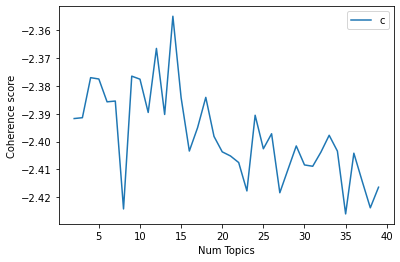

In [29]:
#Wizualizacja zgodności modeli z daną ilością tematów
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#Wniosek: tendencja wskazuje, że wiecej niż 15 nie jest istotne (w przypadku NOUN, NOUN+ADJ)

In [30]:
#Wypisanie każdego z 40 wyników
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -2.3917
Num Topics = 3  has Coherence Value of -2.3914
Num Topics = 4  has Coherence Value of -2.377
Num Topics = 5  has Coherence Value of -2.3775
Num Topics = 6  has Coherence Value of -2.3857
Num Topics = 7  has Coherence Value of -2.3855
Num Topics = 8  has Coherence Value of -2.4242
Num Topics = 9  has Coherence Value of -2.3765
Num Topics = 10  has Coherence Value of -2.3776
Num Topics = 11  has Coherence Value of -2.3895
Num Topics = 12  has Coherence Value of -2.3665
Num Topics = 13  has Coherence Value of -2.3903
Num Topics = 14  has Coherence Value of -2.355
Num Topics = 15  has Coherence Value of -2.3842
Num Topics = 16  has Coherence Value of -2.4034
Num Topics = 17  has Coherence Value of -2.395
Num Topics = 18  has Coherence Value of -2.3841
Num Topics = 19  has Coherence Value of -2.3982
Num Topics = 20  has Coherence Value of -2.4037
Num Topics = 21  has Coherence Value of -2.4052
Num Topics = 22  has Coherence Value of -2.4075
Num

In [31]:
#Wyznaczenie najlepszego wyniku z powyższych 40
optimal_t = [m for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
optimal_n = [cv for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
print("Optimal Num Topics =", optimal_t, " has Coherence Value of", optimal_n)

Optimal Num Topics = [14]  has Coherence Value of [-2.354994349233022]


In [32]:
opt_top = pd.DataFrame(columns=['Num_Topics', 'Coherence_Value'])

In [33]:
#Pętla wykonująca 10 razy ewaluacje 16 modeli LDA i wybór optimum, zapisująca 10 optymalnych rozwiązań do ramki danych

for i in range(10):
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, 
                                                        start=2, limit=16, step=1)
    optimal_t = [m for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
    optimal_n = [cv for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
    opt_top.loc[i] = optimal_t + optimal_n

In [34]:
opt_top.head(10)

,Num_Topics,Coherence_Value
0,7.0,-2.322368
1,5.0,-2.339415
2,5.0,-2.337502
3,5.0,-2.325055
4,5.0,-2.335236
5,7.0,-2.329001
6,6.0,-2.335439
7,5.0,-2.357687
8,6.0,-2.361506
9,3.0,-2.331645


In [35]:
#Wyświetlenie najlepszego wyniku z 10 najlepszych wyników - ostateczny wynik
print(opt_top.loc[opt_top['Coherence_Value'] == opt_top['Coherence_Value'].max()])

   Num_Topics  Coherence_Value
0         7.0        -2.322368


Z powyższej symulacji wynikło, że optymalną liczbą tematów w modelu jest 7.

### Obliczanie modelu

Po przygotowaniu danych w odpowiedniej formie wykonany został algorytm LDA w dwóch wariantach.
1. W pierwszym wariancie liczba tematów do wygenerowania została ustalona arbitralnie, na podstawie teorii marketingowej.
2. W drugim wariancie liczba tematów jest optimum obliczonym przez algorytm symulacyjny. 

##### Obliczanie modelu dla 2 wątków

In [28]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=300, workers=4)

for idx, topic in lda_model.print_topics(-1,15):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.149*"benefit" + 0.123*"family" + 0.117*"vitamin" + 0.114*"juice" + 0.081*"child" + 0.077*"interest" + 0.066*"consumption" + 0.062*"information" + 0.061*"body" + 0.057*"effect" + 0.048*"impact" + 0.040*"value" + 0.001*"support" + 0.001*"nutrition" + 0.000*"care"

Topic: 1 
Words: 0.155*"field" + 0.130*"process" + 0.125*"farmer" + 0.102*"crop" + 0.072*"nature" + 0.067*"cultivation" + 0.061*"care" + 0.055*"grow" + 0.053*"value" + 0.049*"work" + 0.046*"nutrition" + 0.041*"support" + 0.040*"production" + 0.000*"consumption" + 0.000*"vitamin"



In [29]:
#Zapisywanie ciekawszych modeli
from gensim.test.utils import datapath

lda_model.save('D:\\Python\\Projekt dla metodolog.pl\\modele\\lda_noun_1')

##### Obliczanie modelu dla symulowanej liczby wątków

In [36]:
lda_model_sim = gensim.models.LdaMulticore(bow_corpus, num_topics=7, id2word=dictionary, passes=300, workers=4)

for idx, topic in lda_model_sim.print_topics(-1,15):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.347*"process" + 0.198*"grow" + 0.152*"support" + 0.144*"production" + 0.111*"farmer" + 0.043*"care" + 0.000*"body" + 0.000*"consumption" + 0.000*"nature" + 0.000*"benefit" + 0.000*"cultivation" + 0.000*"information" + 0.000*"work" + 0.000*"vitamin" + 0.000*"impact"

Topic: 1 
Words: 0.379*"crop" + 0.249*"cultivation" + 0.182*"work" + 0.130*"process" + 0.036*"care" + 0.019*"consumption" + 0.000*"farmer" + 0.000*"nature" + 0.000*"body" + 0.000*"benefit" + 0.000*"grow" + 0.000*"field" + 0.000*"vitamin" + 0.000*"value" + 0.000*"information"

Topic: 2 
Words: 0.535*"field" + 0.246*"nature" + 0.149*"farmer" + 0.065*"vitamin" + 0.000*"care" + 0.000*"grow" + 0.000*"process" + 0.000*"crop" + 0.000*"work" + 0.000*"value" + 0.000*"support" + 0.000*"benefit" + 0.000*"production" + 0.000*"nutrition" + 0.000*"cultivation"

Topic: 3 
Words: 0.458*"family" + 0.301*"child" + 0.234*"farmer" + 0.000*"body" + 0.000*"value" + 0.000*"support" + 0.000*"care" + 0.000*"vitamin" + 0.000*"cult

In [31]:
#Zapisywanie ciekawszych modeli
from gensim.test.utils import datapath

lda_model_sim.save('D:\\Python\\Projekt dla metodolog.pl\\modele\\lda_noun_2')

#### Wynik - model LDA dla rzeczowników, 2 wątki

In [32]:
lda_model_loaded = gensim.models.LdaMulticore.load('D:\\Python\\Projekt dla metodolog.pl\\modele\\lda_noun_1')

for idx, topic in lda_model_loaded.print_topics(-1,17):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.149*"benefit" + 0.123*"family" + 0.117*"vitamin" + 0.114*"juice" + 0.081*"child" + 0.077*"interest" + 0.066*"consumption" + 0.062*"information" + 0.061*"body" + 0.057*"effect" + 0.048*"impact" + 0.040*"value" + 0.001*"support" + 0.001*"nutrition" + 0.000*"care" + 0.000*"nature" + 0.000*"cultivation"

Topic: 1 
Words: 0.155*"field" + 0.130*"process" + 0.125*"farmer" + 0.102*"crop" + 0.072*"nature" + 0.067*"cultivation" + 0.061*"care" + 0.055*"grow" + 0.053*"value" + 0.049*"work" + 0.046*"nutrition" + 0.041*"support" + 0.040*"production" + 0.000*"consumption" + 0.000*"vitamin" + 0.000*"information" + 0.000*"effect"



#### Wynik - model LDA dla rzeczowników, symulowane wątki

In [1]:
lda_model_loaded = gensim.models.LdaMulticore.load('D:\\Python\\Projekt dla metodolog.pl\\modele\\lda_noun_2')

for idx, topic in lda_model_loaded.print_topics(-1,10):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

NameError: name 'gensim' is not defined